Source: Code/Logic for Association Rules, generators from:
https://www.kaggle.com/datatheque/association-rules-mining-market-basket-analysis

In [47]:
import pandas as pd
import numpy as np
import sys
from itertools import combinations, groupby
from collections import Counter
import matplotlib.pyplot as plt

In [48]:
orders = pd.read_csv('order_products__prior.csv', encoding='latin1')

In [49]:
# Convert from DataFrame to a Series, with order_id as index and item_id as value
orders = orders.set_index('order_id')['product_id'].rename('item_id')
orders.head()

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
Name: item_id, dtype: int64

### Helper Functions

In [50]:
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    # order_item = order_item.reset_index().values()
    order_item = order_item.reset_index()
    order_item['order_id'] = order_item['order_id'].astype(str)
    order_item['item_id'] = order_item['item_id'].astype(str)
    order_item = order_item.to_numpy()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair


# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]

### Assocation rules function

In [51]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs['item_A'] = item_pairs['item_A'].apply(pd.to_numeric, errors='coerce')
    item_pairs['item_B'] = item_pairs['item_B'].apply(pd.to_numeric, errors='coerce')
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
   

    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

### Assocation Rules Output

In [52]:
%%time
rules = association_rules(orders, 0.01)

Starting order_item:               32434489
Items with support >= 0.01:           10906
Remaining order_item:              29843570
Remaining orders with 2+ items:     3013325
Remaining order_item:              29662716
Item pairs:                        30622410
Item pairs with support >= 0.01:      48751

CPU times: user 6min 14s, sys: 3min 8s, total: 9min 23s
Wall time: 10min 41s


In [53]:
# Replace item ID with item name and display association rules
item_name   = pd.read_csv('products.csv')
item_name   = item_name.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, item_name).sort_values('lift', ascending=False)

In [54]:
# Analyze the association rules with hihger lifts and higher confidences
rules2 = rules_final[(rules_final['lift'] > 4) & (rules_final['confidenceAtoB'] > 0.1)]
rules2

,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Organic Strawberry Chia Lowfat 2% Cottage Cheese,Organic Cottage Cheese Blueberry Acai Chia,306,0.010155,1163,0.038595,839,0.027843,0.263113,0.364720,9.449868
1,Grain Free Chicken Formula Cat Food,Grain Free Turkey Formula Cat Food,318,0.010553,1809,0.060033,879,0.029170,0.175788,0.361775,6.026229
3,Organic Fruit Yogurt Smoothie Mixed Berry,Apple Blueberry Fruit Yogurt Smoothie,349,0.011582,1518,0.050376,1249,0.041449,0.229908,0.279424,5.546732
9,Nonfat Strawberry With Fruit On The Bottom Gre...,"0% Greek, Blueberry on the Bottom Yogurt",409,0.013573,1666,0.055288,1391,0.046162,0.245498,0.294033,5.318230
10,Organic Grapefruit Ginger Sparkling Yerba Mate,Cranberry Pomegranate Sparkling Yerba Mate,351,0.011648,1731,0.057445,1149,0.038131,0.202773,0.305483,5.317849
11,Baby Food Pouch - Roasted Carrot Spinach & Beans,"Baby Food Pouch - Butternut Squash, Carrot & C...",332,0.011018,1503,0.049878,1290,0.042810,0.220892,0.257364,5.159830
12,Unsweetened Whole Milk Mixed Berry Greek Yogurt,Unsweetened Whole Milk Blueberry Greek Yogurt,438,0.014535,1622,0.053828,1621,0.053794,0.270037,0.270204,5.019798
23,Uncured Cracked Pepper Beef,Chipotle Beef & Pork Realstick,410,0.013606,1839,0.061029,1370,0.045465,0.222947,0.299270,4.903741
24,Organic Mango Yogurt,Organic Whole Milk Washington Black Cherry Yogurt,334,0.011084,1675,0.055586,1390,0.046128,0.199403,0.240288,4.322777
2,Grain Free Chicken Formula Cat Food,Grain Free Turkey & Salmon Formula Cat Food,391,0.012976,1809,0.060033,1553,0.051538,0.216142,0.251771,4.193848


In [55]:
top10 = rules2.sort_values(by='lift')
top10['itemsets'] = top10['itemA'] + ", " + top10['itemB']

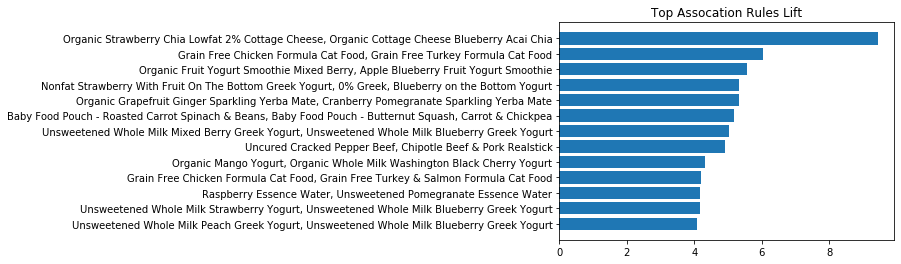

In [56]:
height = top10['lift']
bars = list(top10['itemsets'])
y_pos = np.arange(len(bars))

plt.barh(y_pos, height)
plt.yticks(y_pos, bars)
plt.title('Top Assocation Rules Lift')
plt.show()

#### Specific Product ID search

In [57]:
rules.shape

(48751, 11)

In [62]:
# Insert the product_id in place of the numeric value below
item = item_name[item_name['item_id'] == 47209]
item = item['item_name'].unique()[0]
rules_final[rules_final['itemA'] == item]

,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
33498,Organic Hass Avocado,Organic Large Green Asparagus,3330,0.110509,212785,7.061469,19228,0.638099,0.015650,0.173185,0.024525
34651,Organic Hass Avocado,Organic Large White Flesh Peach,792,0.026283,212785,7.061469,4914,0.163076,0.003722,0.161172,0.022824
44426,Organic Hass Avocado,"Tortillas, Corn, Organic",981,0.032555,212785,7.061469,6090,0.202102,0.004610,0.161084,0.022812
46738,Organic Hass Avocado,Organic Red Cherry Tomato,485,0.016095,212785,7.061469,3026,0.100421,0.002279,0.160278,0.022697
33427,Organic Hass Avocado,Organic Orange Bell Pepper,1576,0.052301,212785,7.061469,10511,0.348817,0.007407,0.149938,0.021233
48551,Organic Hass Avocado,Wild Albacore Tuna No Salt Added,532,0.017655,212785,7.061469,3579,0.118772,0.002500,0.148645,0.021050
47349,Organic Hass Avocado,"Hummus, Hope, Original Recipe",879,0.029170,212785,7.061469,5918,0.196394,0.004131,0.148530,0.021034
16556,Organic Hass Avocado,Organic Lemon,12982,0.430820,212785,7.061469,87497,2.903670,0.061010,0.148371,0.021011
37678,Organic Hass Avocado,Organic English Cucumber,1204,0.039956,212785,7.061469,8144,0.270266,0.005658,0.147839,0.020936
48515,Organic Hass Avocado,Organic Brussel Sprouts,426,0.014137,212785,7.061469,2901,0.096272,0.002002,0.146846,0.020795
